In [102]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import numpy as np 
import pandas as pd
from scipy.linalg import block_diag
from sklearn.metrics import mean_squared_error

In [103]:
def predict(Pk, xhat):
    
    Mk = np.dot(Ak,(Pk @ Ak.T)) + np.dot(Gk,(W @ Gk.T))

    xbar = Ak @ xhat 

    xbar = xbar.reshape(6,1)
    
    return Mk, xbar

In [104]:
df = pd.read_csv('/home/parth/Desktop/uni_stuff/sensor_fusion/project/final_csv_files/cam_lidar_xyz_20Hz.csv')
df.columns = ['time','camera_x','camera_y','camera_z','lidar_x','lidar_y','lidar_z']
gt_hero = pd.read_csv('/home/parth/Desktop/uni_stuff/sensor_fusion/project/final_csv_files/hero_xyz_20Hz.csv')
gt_hero.columns = ['time','x','y','z']

Ak = np.array([[1,0.05,0,0,0,0], [0,1,0,0,0,0], [0,0,1,0.05,0,0], [0,0,0,1,0,0], [0,0,0,0,1,0.05], [0,0,0,0,0,1]]).reshape(6,6)
Hk1 = np.array([[1 ,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,1,0]]).reshape(3,6)
Hk2 = np.array([[1 ,0,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,1,0]]).reshape(3,6)

Hk = np.hstack((Hk1.T,Hk2.T)).T

Gk = np.array([[0.5 * (0.05)**2, 0, 0],
               [(0.05), 0, 0],
               [0, 0.5 * (0.05)**2, 0],
               [0, (0.05), 0],
               [0, 0 , 0.5 * (0.05) **2],
               [0, 0 , (0.05)]]).reshape(6,3)

I = np.eye(6)
Mk = np.eye(6)
Pk = np.eye(6)

x_bar = np.zeros((6, len(df)+1)).reshape(6,len(df)+1)
x_hat = np.zeros((6, len(df)+1)).reshape(6,len(df)+1)
x = np.zeros((6,len(df)+1)).reshape(6,(len(df)+1))
z = np.zeros((12,len(df)+1)).reshape(12,(len(df)+1))

x0 = np.array([[0], [0], [0], [0], [0], [0]]).reshape(6,1)

x_bar[:,0] = x0[:,0]
x[:,0] = x0[:, 0]
x_hat[:,0] = x0[:,0]

sig_w = np.random.normal(0,0.01)
sig_v = np.array([0.01,0.08])


V = sig_v**2

W = np.diag([sig_w**2, sig_w**2, sig_w**2]).reshape(3,3)

In [105]:
for i in range(0,len(df)):
    
    z_m1 = np.array([[(df['camera_x'][i])],[(df['camera_y'][i])], [(df['camera_z'][i])]]).reshape(3,1)
    z_m2 = np.array([[(df['lidar_x'][i])], [(df['lidar_y'][i])], [(df['lidar_z'][i])]]).reshape(3,1)
    
    zs = [z_m1,z_m2]
    
    if i > 0:
        
        xhat = x_hat[:,i]
        
    if i > 0:
        
        M_k, xbar_ = predict(Pk, xhat)
        
        Mk = M_k
        
        x_bar[:,i] = xbar_.flatten()
    
    else:
        
        x_bar[:,i] = x_bar[:,i]
        
        Mk = Mk
        
    H_k = [Hk1,Hk2]
        
    tmp1 = np.zeros((6,1))
    tmp2 = np.zeros((6,6))
        
    for jj in range(0,2):
        
        V_inv = 1./ V[jj]
        
        tmp1 = tmp1 + H_k[jj].T @ (V_inv * zs[jj])
        
        tmp2 = tmp2 + H_k[jj].T @ (V_inv * H_k[jj])
    
    M_inv = np.linalg.inv(Mk)
    
    pk = np.linalg.inv(M_inv + tmp2)
    
    Pk = pk 
    
    x_hat[:,i+1] = Pk @ (M_inv @ x_bar[:,i].reshape(6,1) + tmp1).flatten()
    

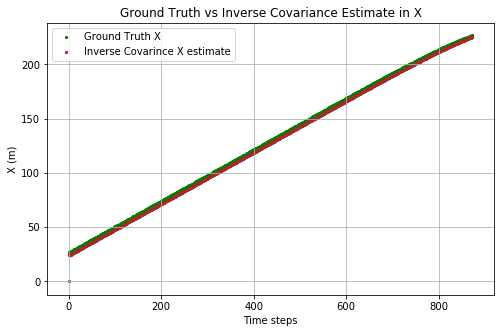

In [106]:
plt.figure(figsize=(8,5))
rn = np.arange(0,len(df+1))
plt.scatter(rn,gt_hero['x'],s=5, label = 'Ground Truth X', c = 'green')
plt.scatter(rn,x_hat[0,:874],s=5, label = 'Inverse Covarince X estimate', c = 'brown')
# plt.scatter(x_hat[0,:874], x_hat[2,:874],s=5)
plt.ylabel('X (m)')
plt.xlabel('Time steps')
plt.title('Ground Truth vs Inverse Covariance Estimate in X')
plt.legend()
plt.grid()

In [111]:
print(np.sqrt(mean_squared_error(gt_hero['x'],x_hat[0,:874],squared=False)))
print(np.sqrt(mean_squared_error(gt_hero['y'],x_hat[2,:874],squared=False)))

1.6440359654778964
2.6581425447713225


In [113]:
print((0.89 + 2.658)/2)

1.774


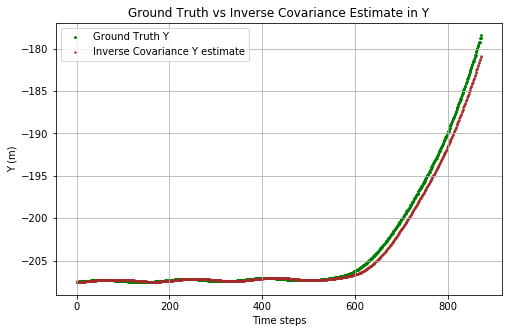

In [109]:
plt.figure(figsize=(8,5))
rn = np.arange(0,len(df+1))
plt.scatter(rn[:873],gt_hero['y'][1:874],s=5, label = 'Ground Truth Y', marker='*', c= 'green')
plt.scatter(rn[:873],x_hat[2,1:874],s=2, label = 'Inverse Covariance Y estimate', c='brown')
plt.ylabel('Y (m)')
plt.xlabel('Time steps')
plt.title('Ground Truth vs Inverse Covariance Estimate in Y')
plt.legend()
plt.grid()

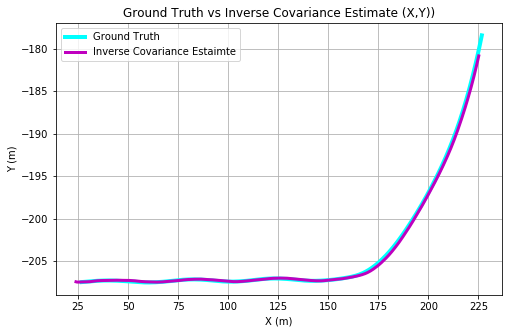

In [110]:
plt.figure(figsize=(8,5))
plt.plot(gt_hero['x'][1:874],gt_hero['y'][1:874],linewidth=4, label = 'Ground Truth', c = 'cyan')
plt.plot(x_hat[0,1:874],x_hat[2,1:874],label = 'Inverse Covariance Estaimte', linewidth=3, c='m', ls='-')
plt.ylabel('Y (m)')
plt.xlabel('X (m)')
plt.title('Ground Truth vs Inverse Covariance Estimate (X,Y))')
plt.legend()
plt.grid()